In [1]:
# General standard libraries:
from typing import Tuple, Any
# General DS libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Data:
from sktime.datasets import load_airline
# Data preparation:
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.utilities.dataframe_functions import impute
# Metric:
from sklearn.metrics import r2_score
# MA model:
from statsmodels.tsa.arima.model import ARIMA
# ROCKET model:
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sktime.transformations.panel.rocket import Rocket
# XGBoost model:
from xgboost import XGBRegressor

# Turn off the warnings:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
def get_train_validation_test(df: pd.DataFrame, column: str, train_ratio: float, valid_points: int):
    target = df[column]
    train_ind = int(train_ratio*len(target.index))
    valid_ind = train_ind + valid_points

    train_limits = df.time.iloc[0], df.time.iloc[train_ind]
    valid_limits = df.time.iloc[train_ind + 1], df.time.iloc[valid_ind]
    test_limits = df.time.iloc[valid_ind + 1], df.time.iloc[-1]
    return train_limits, valid_limits, test_limits

In [11]:
ID = 0
N_VALID_POINTS = 5
TRAIN_RATIO = 0.7
RANDOM_STATE = 13

SAVE_PLOT = True
PLOT_DIR = './pictures/'

# Load and Prepare the Airline Data:

In [4]:
raw_data = load_airline()
ts_df = (
    raw_data
    .to_frame()
    .reset_index()
    .rename(
        {
            'Number of airline passengers': 'n_air_passengers', 
            'Period': 'time',
        },
        axis=1
    )
)
ts_df['time'] = ts_df['time'].apply(lambda x: x.to_timestamp())
ts_df['ts_id'] = ID
ts_df.head()

,time,n_air_passengers,ts_id
0,1949-01-01,112.0,0
1,1949-02-01,118.0,0
2,1949-03-01,132.0,0
3,1949-04-01,129.0,0
4,1949-05-01,121.0,0


In [5]:
train_limits, valid_limits, test_limits = get_train_validation_test(ts_df, 'time', TRAIN_RATIO, N_VALID_POINTS)
train_limits, valid_limits, test_limits

((Timestamp('1949-01-01 00:00:00'), Timestamp('1957-05-01 00:00:00')),
 (Timestamp('1957-06-01 00:00:00'), Timestamp('1957-10-01 00:00:00')),
 (Timestamp('1957-11-01 00:00:00'), Timestamp('1960-12-01 00:00:00')))

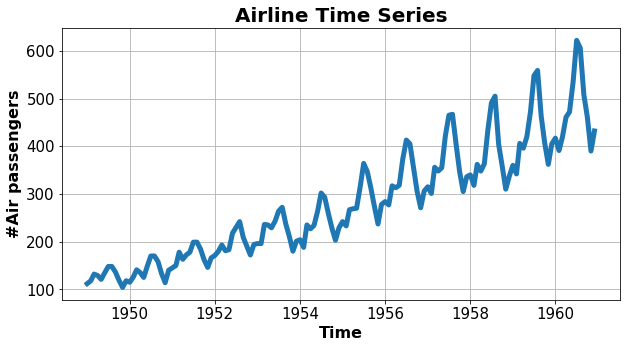

In [29]:
plt.figure(figsize=(10, 5), facecolor='white')
plt.plot(ts_df.time, ts_df.n_air_passengers, linewidth=5.0)
plt.xlabel('Time', fontsize=16, fontweight="bold")
plt.ylabel('#Air passengers', fontsize=16, fontweight="bold")
plt.title('Airline Time Series', fontsize=20, fontweight="bold")
plt.tick_params(labelsize=15)
plt.grid()

if SAVE_PLOT:
    plt.savefig(PLOT_DIR + 'airline_ts.pdf', dpi=400)

# Get several time series using rolling window:

In [7]:
# X data in general ML:
ts_df_rolled = roll_time_series(
    ts_df[['time', 'n_air_passengers', 'ts_id']],
    column_id='ts_id',
    column_sort="time",
    max_timeshift=9, 
    min_timeshift=9
)
# y label in general ML:
y = ts_df[10:].reset_index(drop=True)

display(ts_df_rolled.head())
display(y.head())

Rolling: 100%|██████████| 36/36 [00:00<00:00, 525.30it/s]


,time,n_air_passengers,ts_id,id
0,1949-01-01,112.0,0,"(0, 1949-10-01 00:00:00)"
1,1949-02-01,118.0,0,"(0, 1949-10-01 00:00:00)"
2,1949-03-01,132.0,0,"(0, 1949-10-01 00:00:00)"
3,1949-04-01,129.0,0,"(0, 1949-10-01 00:00:00)"
4,1949-05-01,121.0,0,"(0, 1949-10-01 00:00:00)"


,time,n_air_passengers,ts_id
0,1949-11-01,104.0,0
1,1949-12-01,118.0,0
2,1950-01-01,115.0,0
3,1950-02-01,126.0,0
4,1950-03-01,141.0,0


# Find optimal hyperparameters of models and get the results:

## 1. Moving Average (MA):

### 1.1. Find optimal hyperparameters:

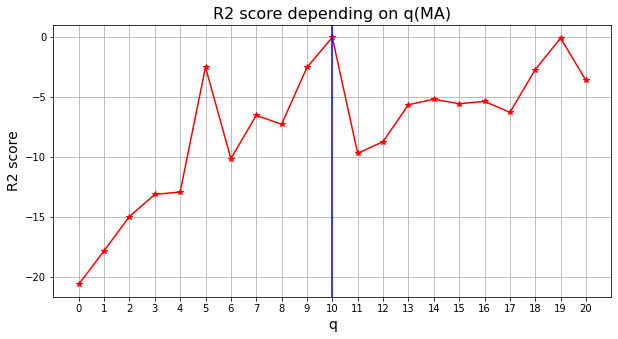

In [8]:
# Train data for MA model:
train_ma = ts_df.query('(time >= @train_limits[0]) and (time <= @train_limits[1])').set_index('time')['n_air_passengers']
# Validation data for MA model:
actual = (
    y
    .query('(time >= @valid_limits[0]) and (time <= @valid_limits[1])')
    .set_index('time')['n_air_passengers']
)
# Parameters for search:
q_options = np.arange(21)
r2_list = []
for q in q_options:
    ma_model = ARIMA(endog=train_ma, order=(0, 0, q))
    ma_results = ma_model.fit()
    prediction = ma_results.forecast(N_VALID_POINTS)
    r2_list.append(r2_score(actual, prediction))

MA_OPTIMAL_Q = q_options[np.argmax(r2_list)]

plt.figure(figsize=(10, 5))
plt.plot(q_options, r2_list, 'r*-')
plt.xticks(q_options)
plt.xlabel('q', fontsize=14)
plt.ylabel('R2 score', fontsize=14)
plt.title('R2 score depending on q(MA)', fontsize=16)
plt.axvline(x=MA_OPTIMAL_Q, color='b')
plt.grid();

### 1.2. Retrain model on train + validation:

In [9]:
# Train-Valid data for MA model:
train_ma = ts_df.query('(time >= @train_limits[0]) and (time <= @valid_limits[1])').set_index('time')['n_air_passengers']
ma_model = ARIMA(endog=train_ma, order=(0, 0, MA_OPTIMAL_Q))
ma_results = ma_model.fit()

### 1.3. Evaluate model on a test set:

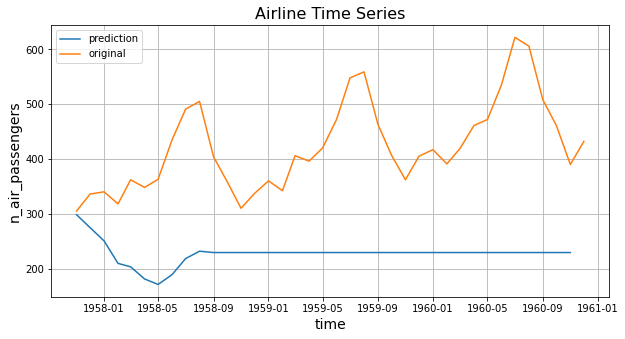

In [10]:
actual = (
    y
    .query('(time >= @test_limits[0]) and (time <= @test_limits[1])')
    .set_index('time')['n_air_passengers']
)
horizon = list(range(2, len(actual)))
r2_horizon_ma = []
for i in horizon:
    prediction = ma_results.forecast(i)
    r2_horizon_ma.append(r2_score(actual[:i], prediction))


plt.figure(figsize=(10, 5))
plt.plot(prediction, label='prediction')
plt.plot(actual, label='original')
plt.xlabel('time', fontsize=14)
plt.ylabel('n_air_passengers', fontsize=14)
plt.title('Airline Time Series', fontsize=16)
plt.legend()
plt.grid();

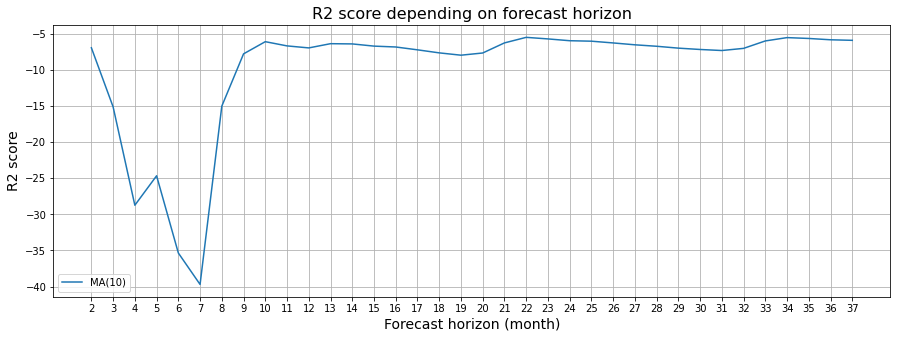

In [11]:
plt.figure(figsize=(15, 5))
plt.plot(horizon, r2_horizon_ma, label=f'MA({MA_OPTIMAL_Q})')
plt.xticks(horizon)
plt.xlabel('Forecast horizon (month)', fontsize=14)
plt.ylabel('R2 score', fontsize=14)
plt.title('R2 score depending on forecast horizon', fontsize=16)
plt.legend()
plt.grid();

## 2. ROCKET:

### 2.1. Find optimal hyperparameters:

#### Prepare the data:

In [12]:
data_x_rocket = np.array(
    ts_df_rolled
    .groupby('id')['n_air_passengers']
    .apply(list)
    .reset_index()[:-1]['n_air_passengers']
    .to_list()
)
data_x_rocket = data_x_rocket.reshape(data_x_rocket.shape[0], 1, data_x_rocket.shape[1])

train_y_rocket = y.query('(time >= @train_limits[0]) and (time <= @valid_limits[1])')
valid_y_rocket = y.query('(time >= @valid_limits[0]) and (time <= @valid_limits[1])')
test_y_rocket = y.query('(time >= @test_limits[0]) and (time <= @test_limits[1])')

train_x_rocket = data_x_rocket[train_y_rocket.index[0]:train_y_rocket.index[-1] + 1]
valid_x_rocket = data_x_rocket[valid_y_rocket.index[0]:valid_y_rocket.index[-1] + 1]
test_x_rocket = data_x_rocket[test_y_rocket.index[0]:test_y_rocket.index[-1] + 1]

train_y_rocket = train_y_rocket['n_air_passengers']
valid_y_rocket = valid_y_rocket['n_air_passengers']
test_y_rocket = test_y_rocket['n_air_passengers']

assert train_x_rocket.shape[0] == train_y_rocket.shape[0]
assert valid_x_rocket.shape[0] == valid_y_rocket.shape[0]
assert test_x_rocket.shape[0] == test_y_rocket.shape[0]

#### Train the model:

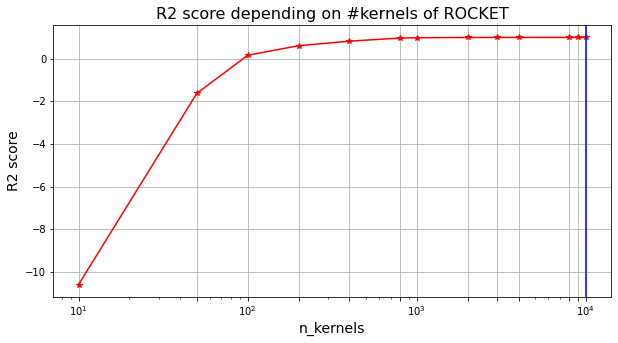

In [13]:
rocket_params = {
    'num_kernels': None,
    'normalise': True,
    'n_jobs': -1,
    'random_state': RANDOM_STATE,
}

ridge_params = {
    'alpha': 1.0, 
    'random_state': RANDOM_STATE,
}

# Parameters for search:
n_kernels_options = [10, 50, 100, 200, 400, 800, 1000, 2000, 3000, 4000, 8000, 9000, 10000]
r2_list = []
for n_kernels in n_kernels_options:
    rocket_params['num_kernels'] = n_kernels
    rocket_pipeline = make_pipeline(
        Rocket(**rocket_params), Ridge(**ridge_params)
    )
    rocket_pipeline.fit(train_x_rocket, train_y_rocket)
    r2_list.append(
        r2_score(
            y_true=valid_y_rocket,
            y_pred=rocket_pipeline.predict(valid_x_rocket)
        )
    )

ROCKET_OPTIMAL_N_KERNELS = n_kernels_options[np.argmax(r2_list)]

plt.figure(figsize=(10, 5))
plt.semilogx(n_kernels_options, r2_list, 'r*-')
plt.xticks(n_kernels_options)
plt.xlabel('n_kernels', fontsize=14)
plt.ylabel('R2 score', fontsize=14)
plt.title('R2 score depending on #kernels of ROCKET', fontsize=16)
plt.axvline(x=ROCKET_OPTIMAL_N_KERNELS, color='b')
plt.grid();

### 2.2. Retrain model on train + validation:

#### Prepare the data:

In [14]:
# Train-Valid data for ROCKET model:
train_x_rocket = np.concatenate([train_x_rocket, valid_x_rocket], axis=0)
train_y_rocket = np.concatenate([train_y_rocket, valid_y_rocket], axis=0)
assert train_x_rocket.shape[0] == train_y_rocket.shape[0]

#### Train the model:

In [15]:
rocket_params['num_kernels'] = ROCKET_OPTIMAL_N_KERNELS
rocket_pipeline = make_pipeline(
    Rocket(**rocket_params), Ridge(**ridge_params)
)
rocket_pipeline.fit(train_x_rocket, train_y_rocket)

Pipeline(steps=[('rocket', Rocket(n_jobs=-1, random_state=13)),
                ('ridge', Ridge(random_state=13))])

### 2.3. Evaluate model on a test set:

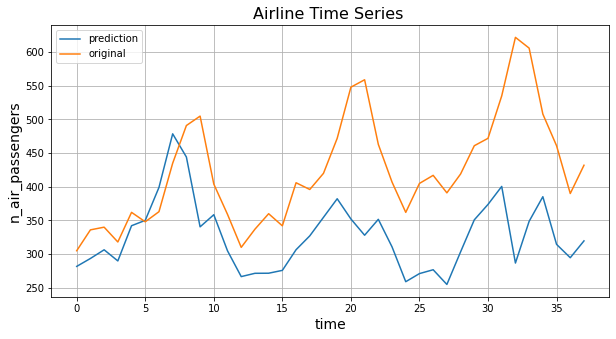

In [16]:
prediction = rocket_pipeline.predict(test_x_rocket)
actual = test_y_rocket.values
horizon = list(range(2, len(actual)))
r2_horizon_rocket = []
for i in horizon:
    r2_horizon_rocket.append(r2_score(actual[:i], prediction[:i]))

plt.figure(figsize=(10, 5))
plt.plot(prediction, label='prediction')
plt.plot(actual, label='original')
plt.xlabel('time', fontsize=14)
plt.ylabel('n_air_passengers', fontsize=14)
plt.title('Airline Time Series ', fontsize=16)
plt.legend()
plt.grid();

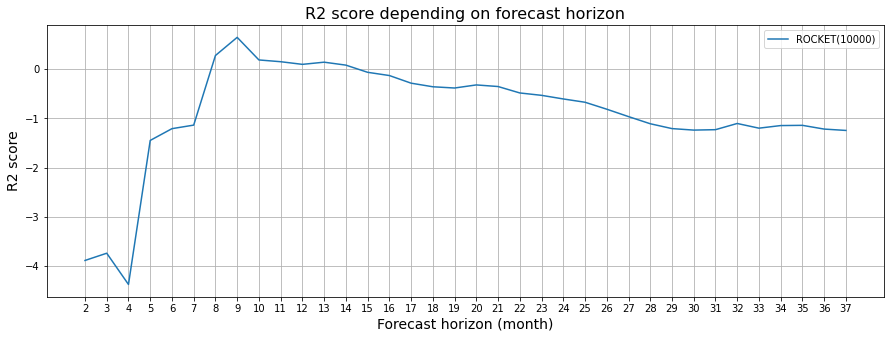

In [17]:
plt.figure(figsize=(15, 5))
plt.plot(horizon, r2_horizon_rocket, label=f'ROCKET({ROCKET_OPTIMAL_N_KERNELS})')
plt.xticks(horizon)
plt.xlabel('Forecast horizon (month)', fontsize=14)
plt.ylabel('R2 score', fontsize=14)
plt.title('R2 score depending on forecast horizon', fontsize=16)
plt.legend()
plt.grid();

## 3. XGBoost:

### 3.1. Find optimal hyperparameters:

#### Prepare the data:

In [18]:
data_x_xgboost = extract_features(
    ts_df_rolled, 
    column_id='id',
    column_sort='time',
    column_value='n_air_passengers', 
    impute_function=impute,
    show_warnings=False,
)[:-1].reset_index(drop=True)

train_y_xgboost = y.query('(time >= @train_limits[0]) and (time <= @valid_limits[1])')
valid_y_xgboost = y.query('(time >= @valid_limits[0]) and (time <= @valid_limits[1])')
test_y_xgboost = y.query('(time >= @test_limits[0]) and (time <= @test_limits[1])')

train_x_xgboost = data_x_xgboost[train_y_xgboost.index[0]:train_y_xgboost.index[-1] + 1]
valid_x_xgboost = data_x_xgboost[valid_y_xgboost.index[0]:valid_y_xgboost.index[-1] + 1]
test_x_xgboost = data_x_xgboost[test_y_xgboost.index[0]:test_y_xgboost.index[-1] + 1]

train_y_xgboost = train_y_xgboost['n_air_passengers']
valid_y_xgboost = valid_y_xgboost['n_air_passengers']
test_y_xgboost = test_y_xgboost['n_air_passengers']

train_x_xgboost = select_features(train_x_xgboost, train_y_xgboost)
valid_x_xgboost = valid_x_xgboost[train_x_xgboost.columns]
test_x_xgboost = test_x_xgboost[train_x_xgboost.columns]

assert train_x_xgboost.shape[0] == train_y_xgboost.shape[0]
assert valid_x_xgboost.shape[0] == valid_y_xgboost.shape[0]
assert test_x_xgboost.shape[0] == test_y_xgboost.shape[0]

Feature Extraction: 100%|██████████| 34/34 [00:00<00:00, 36.42it/s]


#### Train the model:

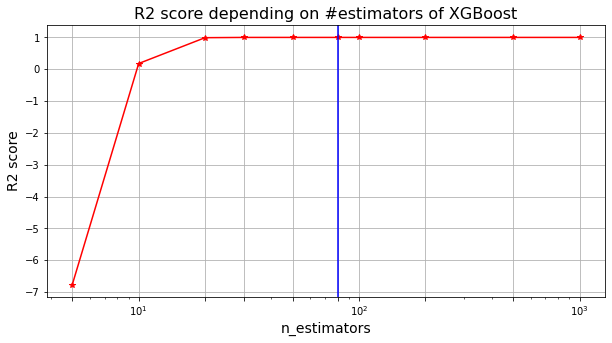

In [19]:
xgboost_params = {
    'n_estimators': None,
    'n_jobs': -1,
    'random_state': RANDOM_STATE,
}

# Parameters for search:
n_estimators_options = [5, 10, 20, 30, 50, 80, 100, 200, 500, 1000]
r2_list = []
for n_estimators in n_estimators_options:
    xgboost_params['n_estimators'] = n_estimators
    xgboost_model = XGBRegressor(**xgboost_params)
    xgboost_model.fit(train_x_xgboost, train_y_xgboost)
    r2_list.append(
        r2_score(
            y_true=valid_y_xgboost,
            y_pred=xgboost_model.predict(valid_x_xgboost)
        )
    )

XGBOOST_OPTIMAL_N_ESTIMATORS = n_estimators_options[np.argmax(r2_list)]

plt.figure(figsize=(10, 5))
plt.semilogx(n_estimators_options, r2_list, 'r*-')
plt.xticks(n_estimators_options)
plt.xlabel('n_estimators', fontsize=14)
plt.ylabel('R2 score', fontsize=14)
plt.title('R2 score depending on #estimators of XGBoost', fontsize=16)
plt.axvline(x=XGBOOST_OPTIMAL_N_ESTIMATORS, color='b')
plt.grid();

### 3.2. Retrain model on train + validation:

#### Prepare the data:

In [20]:
# Train-Valid data for XGBoost model:
train_x_xgboost = np.concatenate([train_x_xgboost, valid_x_xgboost], axis=0)
train_y_xgboost = np.concatenate([train_y_xgboost, valid_y_xgboost], axis=0)
assert train_x_xgboost.shape[0] == train_y_xgboost.shape[0]

#### Train the model:

In [21]:
xgboost_params['n_estimators'] = XGBOOST_OPTIMAL_N_ESTIMATORS
xgboost_model = XGBRegressor(**xgboost_params)
xgboost_model.fit(train_x_xgboost, train_y_xgboost)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=80, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=13,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### 3.3. Evaluate model on a test set:

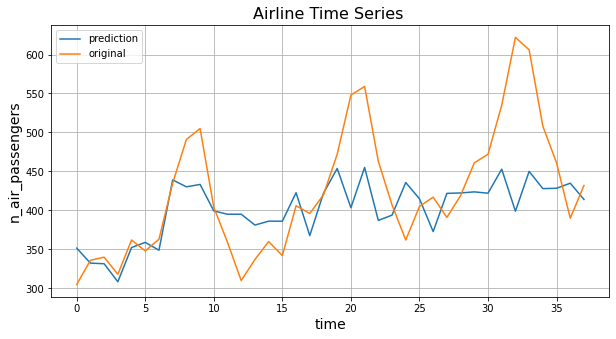

In [22]:
prediction = xgboost_model.predict(test_x_xgboost)
actual = test_y_xgboost.values
horizon = list(range(2, len(actual)))
r2_horizon_xgboost = []
for i in horizon:
    r2_horizon_xgboost.append(r2_score(actual[:i], prediction[:i]))

plt.figure(figsize=(10, 5))
plt.plot(prediction, label='prediction')
plt.plot(actual, label='original')
plt.xlabel('time', fontsize=14)
plt.ylabel('n_air_passengers', fontsize=14)
plt.title('Airline Time Series ', fontsize=16)
plt.legend()
plt.grid();

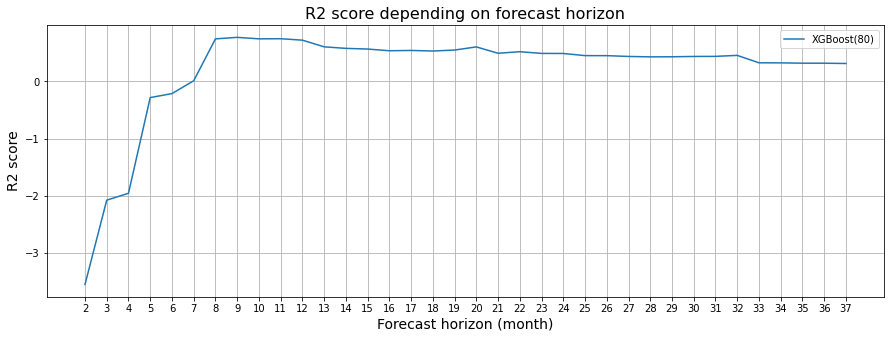

In [23]:
plt.figure(figsize=(15, 5))
plt.plot(horizon, r2_horizon_xgboost, label=f'XGBoost({XGBOOST_OPTIMAL_N_ESTIMATORS})')
plt.xticks(horizon)
plt.xlabel('Forecast horizon (month)', fontsize=14)
plt.ylabel('R2 score', fontsize=14)
plt.title('R2 score depending on forecast horizon', fontsize=16)
plt.legend()
plt.grid();

## 4. LSTM:

In [24]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

from lstm_functions import (
    generate_time_lags,
    generate_cyclical_features,
    LSTMModel,
    SeqDataset,
    Optimization,
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cuda is available.


### 4.1. Find optimal hyperparameters:

#### Prepare the data:

In [25]:
input_dim = 10
ts_df_lstm = ts_df.set_index(['time'])['n_air_passengers'].to_frame()
ts_df_lstm = generate_time_lags(ts_df_lstm, input_dim, 'n_air_passengers')

df_features = (
    ts_df_lstm
    .assign(hour = ts_df_lstm.index.hour)
    .assign(day = ts_df_lstm.index.day)
    .assign(month = ts_df_lstm.index.month)
    .assign(day_of_week = ts_df_lstm.index.dayofweek)
    .assign(week_of_year = ts_df_lstm.index.week)
)

df_features = generate_cyclical_features(df_features, 'hour', 24, 0)
df_features = generate_cyclical_features(df_features, 'day_of_week', 7, 0)
df_features = generate_cyclical_features(df_features, 'month', 12, 1)
df_features = generate_cyclical_features(df_features, 'week_of_year', 52, 0)

data_x_lstm = df_features

train_y_lstm = y.query('(time >= @train_limits[0]) and (time <= @valid_limits[1])')
valid_y_lstm = y.query('(time >= @valid_limits[0]) and (time <= @valid_limits[1])')
test_y_lstm = y.query('(time >= @test_limits[0]) and (time <= @test_limits[1])')

train_x_lstm = data_x_lstm[train_y_lstm.index[0]:train_y_lstm.index[-1] + 1]
valid_x_lstm = data_x_lstm[valid_y_lstm.index[0]:valid_y_lstm.index[-1] + 1]
test_x_lstm = data_x_lstm[test_y_lstm.index[0]:test_y_lstm.index[-1] + 1]

train_y_lstm = train_y_lstm['n_air_passengers'].values.reshape(-1, 1)
valid_y_lstm = valid_y_lstm['n_air_passengers'].values.reshape(-1, 1)
test_y_lstm = test_y_lstm['n_air_passengers'].values.reshape(-1, 1)

assert train_x_lstm.shape[0] == train_y_lstm.shape[0]
assert valid_x_lstm.shape[0] == valid_y_lstm.shape[0]
assert test_x_lstm.shape[0] == test_y_lstm.shape[0]

batch_size = 5

train_features = torch.Tensor(train_x_lstm.to_numpy()).to(device)
train_targets = torch.Tensor(train_y_lstm).to(device)

val_features = torch.Tensor(valid_x_lstm.to_numpy()).to(device)
val_targets = torch.Tensor(valid_y_lstm).to(device)

test_features = torch.Tensor(test_x_lstm.to_numpy()).to(device)
test_targets = torch.Tensor(test_y_lstm).to(device)

train_val_features = torch.Tensor(
    np.concatenate(
        [train_x_lstm.to_numpy(), valid_x_lstm.to_numpy()],
        axis=0
    )
).to(device)
train_val_targets = torch.Tensor(
    np.concatenate(
        [train_y_lstm, valid_y_lstm],
        axis=0
    )
).to(device)

train = SeqDataset(train_features, train_targets, 10)
val = SeqDataset(val_features, val_targets, 10)
train_valid = SeqDataset(train_val_features, train_val_targets, 10)
test = SeqDataset(test_features, test_targets, 10)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
train_val_loader = DataLoader(train_valid, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

/tmp/ipykernel_27984/3593661843.py:11: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  .assign(week_of_year = ts_df_lstm.index.week)


#### Train the model:

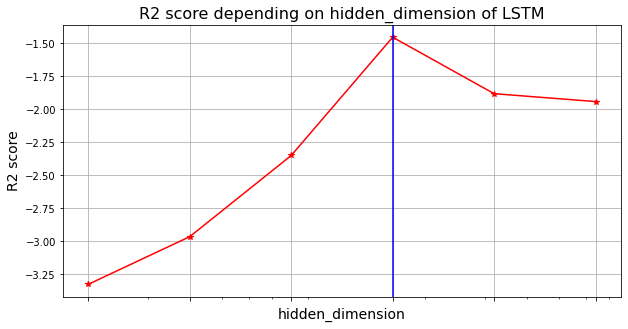

In [26]:
input_dim = len(train_x_lstm.columns)
output_dim = 1
layer_dim = 3
batch_size = 1
dropout = 0.2
n_epochs = 500
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {
    'input_dim': input_dim,
    'hidden_dim' : None,
    'layer_dim' : layer_dim,
    'output_dim' : output_dim,
    'dropout_prob' : dropout,
}

hd_options = [2, 4, 8, 16, 32, 64]
r2_list = []
for hidden_dim in hd_options:
    model_params['hidden_dim'] = hidden_dim
    model = LSTMModel(**model_params).to(device)
    loss_fn = nn.MSELoss(reduction="mean")
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
    opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim, show=False)
    r2_list.append(
        opt.val_metrics[-1]
    )

LSTM_OPTIMAL_HD = hd_options[np.argmax(r2_list)]

plt.figure(figsize=(10, 5))
plt.semilogx(hd_options, r2_list, 'r*-')
plt.xticks(hd_options)
plt.xlabel('hidden_dimension', fontsize=14)
plt.ylabel('R2 score', fontsize=14)
plt.title('R2 score depending on hidden_dimension of LSTM', fontsize=16)
plt.axvline(x=LSTM_OPTIMAL_HD, color='b')
plt.grid();

### 4.2. Retrain model on train + validation:

In [27]:
model_params['hidden_dim'] = LSTM_OPTIMAL_HD

model = LSTMModel(**model_params).to(device)
loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_val_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)

[1/500] Training loss: 67625.1799	 Validation loss: 154834.1094	 Validation r2: -3.9153
[2/500] Training loss: 67418.0944	 Validation loss: 154468.2969	 Validation r2: -3.9037
[3/500] Training loss: 67026.9404	 Validation loss: 153819.5781	 Validation r2: -3.8831
[4/500] Training loss: 66601.0938	 Validation loss: 153159.7500	 Validation r2: -3.8622
[5/500] Training loss: 66201.5771	 Validation loss: 152633.0938	 Validation r2: -3.8455
[6/500] Training loss: 65897.6667	 Validation loss: 152224.1562	 Validation r2: -3.8325
[7/500] Training loss: 65641.3481	 Validation loss: 151874.3594	 Validation r2: -3.8214
[8/500] Training loss: 65414.7966	 Validation loss: 151560.9844	 Validation r2: -3.8114
[9/500] Training loss: 65208.7624	 Validation loss: 151268.6250	 Validation r2: -3.8021
[10/500] Training loss: 65013.0391	 Validation loss: 150989.7500	 Validation r2: -3.7933
[50/500] Training loss: 58803.3035	 Validation loss: 141907.5312	 Validation r2: -3.5050
[100/500] Training loss: 52116

### 4.3. Evaluate model on a test set:

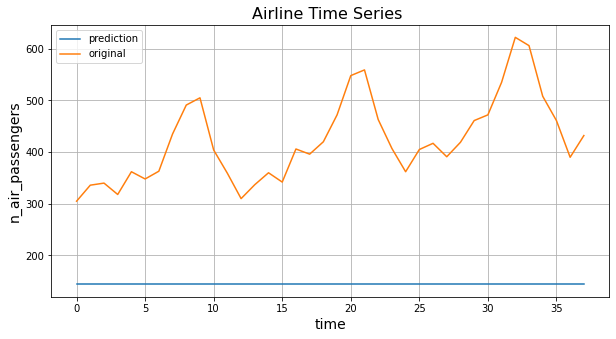

In [40]:
with torch.no_grad():
    predictions = []
    values = []
    for x_test, y_test in test:
        x_test = x_test.view([batch_size, -1, input_dim]).to(device)
        y_test = y_test.to(device)
        model.eval()
        yhat = model(x_test)
        predictions.append(yhat.to(device).cpu().detach().numpy())
        values.append(y_test.to(device).cpu().detach().numpy())

prediction = [i[0, 0] for i in predictions[1:]]
actual = [i[0] for i in values[1:]]
horizon = list(range(2, len(actual)))
r2_horizon_lstm = []
for i in horizon:
    r2_horizon_lstm.append(r2_score(actual[:i], prediction[:i]))

plt.figure(figsize=(10, 5))
plt.plot(prediction, label='prediction')
plt.plot(actual, label='original')
plt.xlabel('time', fontsize=14)
plt.ylabel('n_air_passengers', fontsize=14)
plt.title('Airline Time Series ', fontsize=16)
plt.legend()
plt.grid();

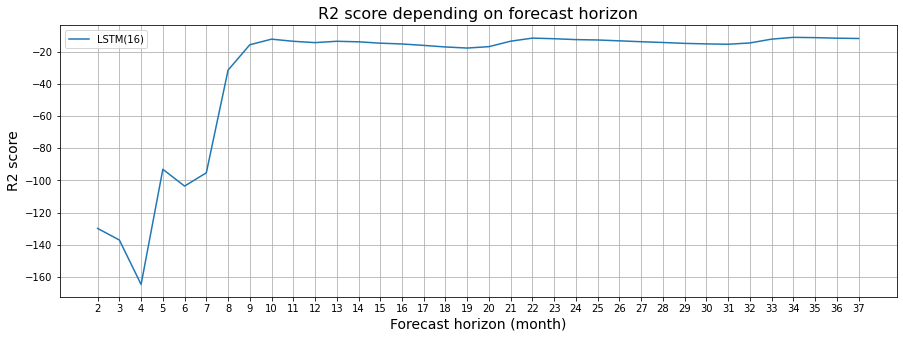

In [41]:
plt.figure(figsize=(15, 5))
plt.plot(horizon, r2_horizon_lstm, label=f'LSTM({LSTM_OPTIMAL_HD})')
plt.xticks(horizon)
plt.xlabel('Forecast horizon (month)', fontsize=14)
plt.ylabel('R2 score', fontsize=14)
plt.title('R2 score depending on forecast horizon', fontsize=16)
plt.legend()
plt.grid();

# Final considerations:

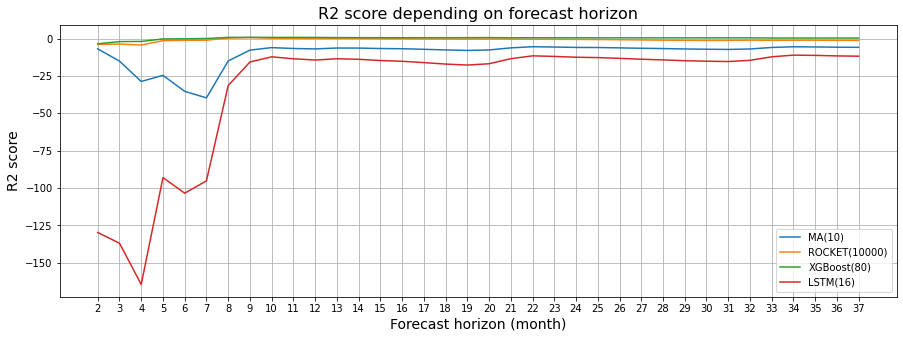

In [42]:
plt.figure(figsize=(15, 5))
plt.plot(horizon, r2_horizon_ma, label=f'MA({MA_OPTIMAL_Q})')
plt.plot(horizon, r2_horizon_rocket, label=f'ROCKET({ROCKET_OPTIMAL_N_KERNELS})')
plt.plot(horizon, r2_horizon_xgboost, label=f'XGBoost({XGBOOST_OPTIMAL_N_ESTIMATORS})')
plt.plot(horizon, r2_horizon_lstm, label=f'LSTM({LSTM_OPTIMAL_HD})')
plt.xticks(horizon)
plt.xlabel('Forecast horizon (month)', fontsize=14)
plt.ylabel('R2 score', fontsize=14)
plt.title('R2 score depending on forecast horizon', fontsize=16)
plt.legend()
plt.grid();